In [168]:
#% reset
import tensorflow as tf
import numpy as np
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryFile
import random
import midi_musical_matrix
import data
import multi_training
from tensorflow.contrib.rnn import BasicLSTMCell
from tensorflow.contrib.rnn import LSTMStateTuple
from MyFunctions import Input_Kernel, LSTM_TimeWise_Training_Layer, LSTM_NoteWise_Layer, Loss_Function

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
# Import All Training and Validation Data
# Convert Entire Music .MIDI set to list of musical 'pieces'
# During training runs, getPieceBatch will return a tensor for Note_State_Batch, and corresponding Note_State_Expand
# Note_State_Expand will be fed into the graph input, and Note_State_Batch will be used for the loss function.


# Import Midi files to list
Working_Directory = os.getcwd()
Music_Directory = Working_Directory + "/Midi_Files/Piano_Midi/"
print(Working_Directory)
Midi_Directories = ["albeniz", "beeth", "borodin", "brahms", "burgm", "Chopin", "debussy", "granados", "grieg", "haydn", "liszt", "mendelssohn", "mozart", "muss", "schubert", "schumann", "tschai"]
max_time_steps = 256 # only files atleast this many 16th note steps are saved
num_validation_pieces=10


# Gather the training pieces from the specified directories
training_pieces={}
for f in range(len(Midi_Directories)):
    Training_Midi_Folder = Music_Directory + Midi_Directories[f]
    training_pieces = {**training_pieces, **multi_training.loadPieces(Training_Midi_Folder, max_time_steps)}

# Set aside a random set of pieces for validation purposes
validation_pieces={}
for v in range(num_validation_pieces):
    index = random.choice(list(training_pieces.keys()))
    validation_pieces[index] = training_pieces.pop(index)
    
    
print('')
print('Number of training pieces = ', len(training_pieces))    
print('Number of validation pieces = ', len(validation_pieces))     
    
    

# Generate sample Note State Matrix for dimension measurement and numerical checking purposes
# (Using external code to generate the Note State Matrix but using our own NoteInputForm (as defined in author's code) function
practice_batch_size = 15
practice_num_timesteps = 128

_, sample_state = multi_training.getPieceBatch(training_pieces, practice_batch_size, practice_num_timesteps)
sample_state = np.array(sample_state)
sample_state = np.swapaxes(sample_state, axis1=1, axis2=2)
print('Sample of State Input Batch: shape = ', sample_state.shape)






/home/ecbm4040/Music_Project/Generating_Music
Loaded alb_esp5
Loaded alb_esp2
Loaded appass_3
Loaded mond_1
Loaded beethoven_opus10_3
Loaded pathetique_3
Loaded waldstein_3
Loaded mond_3
Loaded beethoven_les_adieux_2
Loaded beethoven_opus22_4
Loaded waldstein_1
Loaded beethoven_hammerklavier_1
Loaded appass_2
Loaded beethoven_les_adieux_1
Loaded beethoven_opus22_1
Loaded beethoven_opus10_2
Loaded pathetique_1
Loaded beethoven_opus90_2
Loaded bor_ps7
Loaded bor_ps1
Loaded bor_ps5
Loaded brahms_opus1_1
Loaded brahms_opus1_2
Loaded br_rhap
Loaded burg_spinnerlied
Loaded burg_erwachen
Loaded burg_agitato
Loaded burg_gewitter
Loaded burg_trennung
Loaded burg_quelle
Loaded chpn-p23
Loaded chpn-p4
Loaded chpn_op35_4
Loaded chpn-p3
Loaded chpn-p14
Loaded chpn-p2
Loaded chpn_op25_e2
Loaded chpn_op25_e12
Loaded chpn-p16
Loaded chpn-p15
Loaded chpn_op25_e11
Loaded chpn_op25_e1
Loaded chpn_op27_1
Loaded chpn_op66
Loaded chpn_op35_3
Loaded chpn_op25_e4
Loaded chpn-p8
Loaded chpn_op35_1
Loaded DEB_P

In [175]:
# Build the Model Graph:
tf.reset_default_graph()
print('Building Graph...')
#Capture number of notes from sample
num_notes = sample_state.shape[1]

# Graph Input Placeholders
Note_State_Batch = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 2])
time_init = tf.placeholder(dtype=tf.int32, shape=())

#Generate expanded tensor from batch of note state matrices
# Essential the CNN 'window' of this network
Note_State_Expand = Input_Kernel(Note_State_Batch, Midi_low=24, Midi_high=101, time_init=time_init)

print('Note_State_Expand shape = ', Note_State_Expand.get_shape())


# lSTM Time Wise Training Graph 
num_t_units=[200, 200]
output_keep_prob = tf.placeholder(dtype=tf.float32, shape=())

# Generate initial state (at t=0) placeholder
timewise_state=[]
for i in range(len(num_t_units)):
    timewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]]) #None = batch_size * num_notes
    timewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]])
    timewise_state.append(LSTMStateTuple(timewise_h, timewise_c))

timewise_state=tuple(timewise_state)


timewise_out, timewise_state_out = LSTM_TimeWise_Training_Layer(input_data=Note_State_Expand, state_init=timewise_state, output_keep_prob=output_keep_prob)

print('Time-wise output shape = ', timewise_out.get_shape())




#LSTM Note Wise Graph

num_n_units = [100, 100]

# Generate initial state (at n=0) placeholder
notewise_state=[]
for i in range(len(num_n_units)):
    notewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]]) #None = batch_size * num_timesteps
    notewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]])
    notewise_state.append(LSTMStateTuple(notewise_h, notewise_c))

notewise_state=tuple(notewise_state)


y_out, note_gen_out = LSTM_NoteWise_Layer(timewise_out, state_init=notewise_state, output_keep_prob=output_keep_prob)

p_out = tf.sigmoid(y_out)
print('y_out shape = ', y_out.get_shape())
print('generated samples shape = ', note_gen_out.get_shape())



# Loss Function and Optimizer

loss, log_likelihood = Loss_Function(Note_State_Batch, y_out)
optimizer = tf.train.AdadeltaOptimizer(learning_rate = 1).minimize(loss)
#optimizer = tf.train.RMSPropOptimizer
print('Graph Building Complete')



Building Graph...
Note_State_Expand shape =  (?, 78, ?, 80)
Time-wise output shape =  (?, 78, ?, 200)
y_out shape =  (?, 78, ?, 2)
generated samples shape =  (?, 78, ?, 2)
Graph Building Complete


creating new destination folder
destination folder exists
Load the model from: Long_Train
INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train/Long_Train


INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train/Long_Train


Obtaining new batch of pieces
epoch =  0  /  50000 :
Training loss =  0.0615164 ; Training log likelihood =  -4.79828
Validation loss =  0.0741544 ; Validation log likelihood =  -5.78404
Obtaining new batch of pieces
epoch =  100  /  50000 :
Training loss =  0.0701507 ; Training log likelihood =  -5.47175
Validation loss =  0.0605815 ; Validation log likelihood =  -4.72535
Obtaining new batch of pieces
epoch =  200  /  50000 :
Training loss =  0.0542527 ; Training log likelihood =  -4.23171
Validation loss =  0.0753748 ; Validation log likelihood =  -5.87924
Obtaining new batch of pieces
epoch =  300  /  50000 :
Training loss =  0.076291 ; Training log likelihood =  -5.9507
Validation loss =  0.0657006 ; Validation log likelihood =  -5.12464
Obtaining new batch of pieces
epoch =  400  /  50000 :
Training loss =  0.0716448 ; Training log likelihood =  -5.5883
Validation loss =  0.0734914 ; Validation log likelihood =  -5.73233
Obtaining new batch of pieces
epoch =  500  /  50000 :
Train

epoch =  4100  /  50000 :
Training loss =  0.0657868 ; Training log likelihood =  -5.13137
Validation loss =  0.0632973 ; Validation log likelihood =  -4.93719
Obtaining new batch of pieces
epoch =  4200  /  50000 :
Training loss =  0.0772907 ; Training log likelihood =  -6.02867
Validation loss =  0.0607997 ; Validation log likelihood =  -4.74238
Obtaining new batch of pieces
epoch =  4300  /  50000 :
Training loss =  0.0694562 ; Training log likelihood =  -5.41759
Validation loss =  0.0802152 ; Validation log likelihood =  -6.25678
Obtaining new batch of pieces
epoch =  4400  /  50000 :
Training loss =  0.0793236 ; Training log likelihood =  -6.18724
Validation loss =  0.0531121 ; Validation log likelihood =  -4.14274
Obtaining new batch of pieces
epoch =  4500  /  50000 :
Training loss =  0.0761032 ; Training log likelihood =  -5.93605
Validation loss =  0.0802044 ; Validation log likelihood =  -6.25595
Obtaining new batch of pieces
epoch =  4600  /  50000 :
Training loss =  0.05922

Obtaining new batch of pieces
epoch =  8300  /  50000 :
Training loss =  0.0618561 ; Training log likelihood =  -4.82478
Validation loss =  0.0593403 ; Validation log likelihood =  -4.62854
Obtaining new batch of pieces
epoch =  8400  /  50000 :
Training loss =  0.0839849 ; Training log likelihood =  -6.55083
Validation loss =  0.0520894 ; Validation log likelihood =  -4.06298
Obtaining new batch of pieces
epoch =  8500  /  50000 :
Training loss =  0.0779082 ; Training log likelihood =  -6.07684
Validation loss =  0.0706305 ; Validation log likelihood =  -5.50918
Obtaining new batch of pieces
epoch =  8600  /  50000 :
Training loss =  0.0625447 ; Training log likelihood =  -4.87849
Validation loss =  0.0660578 ; Validation log likelihood =  -5.1525
Obtaining new batch of pieces
epoch =  8700  /  50000 :
Training loss =  0.0642437 ; Training log likelihood =  -5.01101
Validation loss =  0.0533817 ; Validation log likelihood =  -4.16377
Obtaining new batch of pieces
epoch =  8800  /  500

Obtaining new batch of pieces
epoch =  12400  /  50000 :
Training loss =  0.0696389 ; Training log likelihood =  -5.43184
Validation loss =  0.0735883 ; Validation log likelihood =  -5.73989
Obtaining new batch of pieces
epoch =  12500  /  50000 :
Training loss =  0.0924101 ; Training log likelihood =  -7.20799
Validation loss =  0.0589549 ; Validation log likelihood =  -4.59848
Obtaining new batch of pieces
epoch =  12600  /  50000 :
Training loss =  0.0608066 ; Training log likelihood =  -4.74292
Validation loss =  0.0570606 ; Validation log likelihood =  -4.45073
Obtaining new batch of pieces
epoch =  12700  /  50000 :
Training loss =  0.0613207 ; Training log likelihood =  -4.78301
Validation loss =  0.0497035 ; Validation log likelihood =  -3.87687
Obtaining new batch of pieces
epoch =  12800  /  50000 :
Training loss =  0.0812513 ; Training log likelihood =  -6.3376
Validation loss =  0.0668766 ; Validation log likelihood =  -5.21638
Obtaining new batch of pieces
epoch =  12900  

Obtaining new batch of pieces
epoch =  16500  /  50000 :
Training loss =  0.0640675 ; Training log likelihood =  -4.99727
Validation loss =  0.0897397 ; Validation log likelihood =  -6.99969
Obtaining new batch of pieces
epoch =  16600  /  50000 :
Training loss =  0.0723901 ; Training log likelihood =  -5.64643
Validation loss =  0.0724149 ; Validation log likelihood =  -5.64836
Obtaining new batch of pieces
epoch =  16700  /  50000 :
Training loss =  0.0803807 ; Training log likelihood =  -6.2697
Validation loss =  0.0580401 ; Validation log likelihood =  -4.52713
Obtaining new batch of pieces
epoch =  16800  /  50000 :
Training loss =  0.0739729 ; Training log likelihood =  -5.76989
Validation loss =  0.0411099 ; Validation log likelihood =  -3.20657
Obtaining new batch of pieces
epoch =  16900  /  50000 :
Training loss =  0.0653798 ; Training log likelihood =  -5.09963
Validation loss =  0.0610747 ; Validation log likelihood =  -4.76382
Obtaining new batch of pieces
Model saved in f

Obtaining new batch of pieces
epoch =  20600  /  50000 :
Training loss =  0.065955 ; Training log likelihood =  -5.14449
Validation loss =  0.0735873 ; Validation log likelihood =  -5.73981
Obtaining new batch of pieces
epoch =  20700  /  50000 :
Training loss =  0.0878386 ; Training log likelihood =  -6.85141
Validation loss =  0.0615958 ; Validation log likelihood =  -4.80447
Obtaining new batch of pieces
epoch =  20800  /  50000 :
Training loss =  0.0651456 ; Training log likelihood =  -5.08136
Validation loss =  0.0653979 ; Validation log likelihood =  -5.10103
Obtaining new batch of pieces
epoch =  20900  /  50000 :
Training loss =  0.0785661 ; Training log likelihood =  -6.12816
Validation loss =  0.0760054 ; Validation log likelihood =  -5.92842
Obtaining new batch of pieces
Model saved in file: /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train_256/Long_Train_256
epoch =  21000  /  50000 :
Training loss =  0.0681997 ; Training log likelihood =  -5.31957
Validation 

Obtaining new batch of pieces
epoch =  24700  /  50000 :
Training loss =  0.0793755 ; Training log likelihood =  -6.19129
Validation loss =  0.0676883 ; Validation log likelihood =  -5.27969
Obtaining new batch of pieces
epoch =  24800  /  50000 :
Training loss =  0.0841414 ; Training log likelihood =  -6.56303
Validation loss =  0.0715549 ; Validation log likelihood =  -5.58128
Obtaining new batch of pieces
epoch =  24900  /  50000 :
Training loss =  0.0643773 ; Training log likelihood =  -5.02143
Validation loss =  0.0540009 ; Validation log likelihood =  -4.21207
Obtaining new batch of pieces
Model saved in file: /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train_256/Long_Train_256
epoch =  25000  /  50000 :
Training loss =  0.0788159 ; Training log likelihood =  -6.14764
Validation loss =  0.0712939 ; Validation log likelihood =  -5.56093
Obtaining new batch of pieces
epoch =  25100  /  50000 :
Training loss =  0.0706717 ; Training log likelihood =  -5.51239
Validation

Obtaining new batch of pieces
epoch =  28800  /  50000 :
Training loss =  0.0627909 ; Training log likelihood =  -4.89769
Validation loss =  0.0775958 ; Validation log likelihood =  -6.05247
Obtaining new batch of pieces
epoch =  28900  /  50000 :
Training loss =  0.0775482 ; Training log likelihood =  -6.04876
Validation loss =  0.0714859 ; Validation log likelihood =  -5.5759
Obtaining new batch of pieces
Model saved in file: /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train_256/Long_Train_256
epoch =  29000  /  50000 :
Training loss =  0.0656453 ; Training log likelihood =  -5.12033
Validation loss =  0.0777536 ; Validation log likelihood =  -6.06478
Obtaining new batch of pieces
epoch =  29100  /  50000 :
Training loss =  0.0755447 ; Training log likelihood =  -5.89249
Validation loss =  0.0778591 ; Validation log likelihood =  -6.07301
Obtaining new batch of pieces
epoch =  29200  /  50000 :
Training loss =  0.0714323 ; Training log likelihood =  -5.57172
Validation 

Obtaining new batch of pieces
epoch =  32900  /  50000 :
Training loss =  0.0915479 ; Training log likelihood =  -7.14073
Validation loss =  0.0770295 ; Validation log likelihood =  -6.0083
Obtaining new batch of pieces
Model saved in file: /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train_256/Long_Train_256
epoch =  33000  /  50000 :
Training loss =  0.0478529 ; Training log likelihood =  -3.73253
Validation loss =  0.050471 ; Validation log likelihood =  -3.93674
Obtaining new batch of pieces
epoch =  33100  /  50000 :
Training loss =  0.0649777 ; Training log likelihood =  -5.06826
Validation loss =  0.0594366 ; Validation log likelihood =  -4.63605
Obtaining new batch of pieces
epoch =  33200  /  50000 :
Training loss =  0.0802766 ; Training log likelihood =  -6.26157
Validation loss =  0.066871 ; Validation log likelihood =  -5.21594
Obtaining new batch of pieces
epoch =  33300  /  50000 :
Training loss =  0.067578 ; Training log likelihood =  -5.27109
Validation los

Obtaining new batch of pieces
Model saved in file: /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train_256/Long_Train_256
epoch =  37000  /  50000 :
Training loss =  0.0737576 ; Training log likelihood =  -5.75309
Validation loss =  0.0469563 ; Validation log likelihood =  -3.66259
Obtaining new batch of pieces
epoch =  37100  /  50000 :
Training loss =  0.0745606 ; Training log likelihood =  -5.81573
Validation loss =  0.0478944 ; Validation log likelihood =  -3.73577
Obtaining new batch of pieces
epoch =  37200  /  50000 :
Training loss =  0.0711436 ; Training log likelihood =  -5.5492
Validation loss =  0.0728757 ; Validation log likelihood =  -5.6843
Obtaining new batch of pieces
epoch =  37300  /  50000 :
Training loss =  0.0819194 ; Training log likelihood =  -6.38971
Validation loss =  0.0792563 ; Validation log likelihood =  -6.18199
Obtaining new batch of pieces
epoch =  37400  /  50000 :
Training loss =  0.0829631 ; Training log likelihood =  -6.47113
Validation l

Obtaining new batch of pieces
epoch =  41100  /  50000 :
Training loss =  0.0687103 ; Training log likelihood =  -5.35941
Validation loss =  0.0718441 ; Validation log likelihood =  -5.60384
Obtaining new batch of pieces
epoch =  41200  /  50000 :
Training loss =  0.0664095 ; Training log likelihood =  -5.17994
Validation loss =  0.0646825 ; Validation log likelihood =  -5.04524
Obtaining new batch of pieces
epoch =  41300  /  50000 :
Training loss =  0.0806411 ; Training log likelihood =  -6.29
Validation loss =  0.029858 ; Validation log likelihood =  -2.32893
Obtaining new batch of pieces
epoch =  41400  /  50000 :
Training loss =  0.0496558 ; Training log likelihood =  -3.87315
Validation loss =  0.0654115 ; Validation log likelihood =  -5.1021
Obtaining new batch of pieces
epoch =  41500  /  50000 :
Training loss =  0.0708106 ; Training log likelihood =  -5.52323
Validation loss =  0.0555548 ; Validation log likelihood =  -4.33328
Obtaining new batch of pieces
epoch =  41600  /  5

Obtaining new batch of pieces
epoch =  45200  /  50000 :
Training loss =  0.0722246 ; Training log likelihood =  -5.63352
Validation loss =  0.0931256 ; Validation log likelihood =  -7.2638
Obtaining new batch of pieces
epoch =  45300  /  50000 :
Training loss =  0.0673891 ; Training log likelihood =  -5.25635
Validation loss =  0.0825977 ; Validation log likelihood =  -6.44262
Obtaining new batch of pieces
epoch =  45400  /  50000 :
Training loss =  0.0607527 ; Training log likelihood =  -4.73871
Validation loss =  0.0775668 ; Validation log likelihood =  -6.05021
Obtaining new batch of pieces
epoch =  45500  /  50000 :
Training loss =  0.0692395 ; Training log likelihood =  -5.40068
Validation loss =  0.079109 ; Validation log likelihood =  -6.17051
Obtaining new batch of pieces
epoch =  45600  /  50000 :
Training loss =  0.0604913 ; Training log likelihood =  -4.71832
Validation loss =  0.0706607 ; Validation log likelihood =  -5.51153
Obtaining new batch of pieces
epoch =  45700  /

Obtaining new batch of pieces
epoch =  49300  /  50000 :
Training loss =  0.0522401 ; Training log likelihood =  -4.07472
Validation loss =  0.0573159 ; Validation log likelihood =  -4.47064
Obtaining new batch of pieces
epoch =  49400  /  50000 :
Training loss =  0.0695155 ; Training log likelihood =  -5.42221
Validation loss =  0.0463311 ; Validation log likelihood =  -3.61383
Obtaining new batch of pieces
epoch =  49500  /  50000 :
Training loss =  0.0621427 ; Training log likelihood =  -4.84713
Validation loss =  0.0676137 ; Validation log likelihood =  -5.27387
Obtaining new batch of pieces
epoch =  49600  /  50000 :
Training loss =  0.0638581 ; Training log likelihood =  -4.98093
Validation loss =  0.0710147 ; Validation log likelihood =  -5.53915
Obtaining new batch of pieces
epoch =  49700  /  50000 :
Training loss =  0.0851044 ; Training log likelihood =  -6.63815
Validation loss =  0.0543954 ; Validation log likelihood =  -4.24284
Obtaining new batch of pieces
epoch =  49800 

<function matplotlib.pyplot.show>

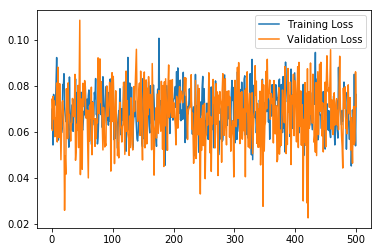

In [176]:
# Training

start_time = time.time()
N_epochs = 50000
loss_hist=[]
loss_valid_hist=[]
restore_model_name = 'Long_Train'
save_model_name = 'Long_Train_256'
batch_size = 5
num_timesteps = 256
keep_prob=.5

# Save Model
Output_Directory = Working_Directory + "/Output/" + save_model_name
directory = os.path.dirname(Output_Directory)

try:
    print('creating new destination folder')
    os.mkdir(directory)    
except:
    print('destination folder exists')
            

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    # try to restore the pre_trained
    if restore_model_name is not None:
        Load_Directory = Working_Directory + "/Output/" + restore_model_name
               
        print("Load the model from: {}".format(restore_model_name))
        saver.restore(sess, Load_Directory + '/{}'.format(restore_model_name))
        
    
    # Initial States
    timewise_state_val=[]
    for i in range(len(num_t_units)):
        c_t = np.zeros((batch_size*num_notes, num_t_units[i])) #start every batch with zero state in LSTM time cells
        h_t = np.zeros((batch_size*num_notes, num_t_units[i]))
        timewise_state_val.append(LSTMStateTuple(h_t, c_t))
        
    notewise_state_val=[]
    for i in range(len(num_n_units)):
        c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
        h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
        notewise_state_val.append(LSTMStateTuple(h_n, c_n))
    
  

    # Training Loop
    for epoch in range(N_epochs+1):
        
        # Generate random batch of training data        
        if (epoch % 100 == 0):         
            print('Obtaining new batch of pieces')
            _, batch_input_state = multi_training.getPieceBatch(training_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
            batch_input_state = np.array(batch_input_state)
            batch_input_state = np.swapaxes(batch_input_state, axis1=1, axis2=2)           
       

        # Run Session
        feed_dict = {Note_State_Batch: batch_input_state, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: keep_prob}
        loss_run, log_likelihood_run, _, note_gen_out_run = sess.run([loss, log_likelihood, optimizer, note_gen_out], feed_dict=feed_dict)

        
        # Periodically save model and loss histories
        if (epoch % 1000 == 0) & (epoch > 0):
            save_path = saver.save(sess, Output_Directory + '/{}'.format(save_model_name))
            print("Model saved in file: %s" % save_path)
            np.save(Output_Directory + "/ training_loss.npy", loss_hist)
            np.save(Output_Directory + "/ valid_loss.npy", loss_valid)
        
        # Regularly Calculate Validation loss and store both training and validation losses
        if (epoch % 100) == 0 & (epoch > 0):
            # Calculation Validation loss
            _, batch_input_state_valid = multi_training.getPieceBatch(validation_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
            batch_input_state_valid = np.array(batch_input_state_valid)
            batch_input_state_valid = np.swapaxes(batch_input_state_valid, axis1=1, axis2=2)    
            feed_dict = {Note_State_Batch: batch_input_state_valid, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: keep_prob}
            loss_valid, log_likelihood_valid = sess.run([loss, log_likelihood], feed_dict=feed_dict)
            
            print('epoch = ', epoch, ' / ', N_epochs, ':')
            print('Training loss = ', loss_run, '; Training log likelihood = ', log_likelihood_run)
            print('Validation loss = ', loss_valid, '; Validation log likelihood = ', log_likelihood_valid)
            
            loss_hist.append(loss_run)
            loss_valid_hist.append(loss_valid)
        
        # Periodically generate Sample of music
            

end_time = time.time()

print('Training time = ', end_time - start_time, ' seconds')

# Plot the loss histories
plt.plot(loss_hist, label="Training Loss")
plt.plot(loss_valid_hist, label="Validation Loss")
plt.legend()
plt.show

Load the model from: Piano_Midi2
INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Piano_Midi2/Piano_Midi2


INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Piano_Midi2/Piano_Midi2


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<function matplotlib.pyplot.show>

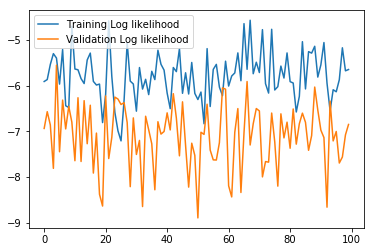

In [117]:
# Generate Final Test and Validation Likelihoods 
keep_prob=1
training_loss_ave=[]
validation_loss_ave=[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # try to restore the pre_trained
    if restore_model_name is not None:
        print("Load the model from: {}".format(save_model_name))
        saver.restore(sess, Load_Directory + '/{}'.format(save_model_name))
    
    # Initial States
    timewise_state_val=[]
    for i in range(len(num_t_units)):
        c_t = np.zeros((batch_size*num_notes, num_t_units[i])) #start every batch with zero state in LSTM time cells
        h_t = np.zeros((batch_size*num_notes, num_t_units[i]))
        timewise_state_val.append(LSTMStateTuple(h_t, c_t))
        
    notewise_state_val=[]
    for i in range(len(num_n_units)):
        c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
        h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
        notewise_state_val.append(LSTMStateTuple(h_n, c_n))
        
    for p in range(10):
        _, batch_input_state_test = multi_training.getPieceBatch(training_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
        batch_input_state_test = np.array(batch_input_state_test)
        batch_input_state_test = np.swapaxes(batch_input_state_test, axis1=1, axis2=2) 
        
        # Run Session
        feed_dict = {Note_State_Batch: batch_input_state_test, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: 1}
        loss_run, log_likelihood_run, note_gen_out_run = sess.run([loss, log_likelihood, note_gen_out], feed_dict=feed_dict)                                                           
        training_loss_ave.append(-78*loss_run)
        
        _, batch_input_state_valid = multi_training.getPieceBatch(validation_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
        batch_input_state_valid = np.array(batch_input_state_valid)
        batch_input_state_valid = np.swapaxes(batch_input_state_valid, axis1=1, axis2=2) 
        
        # Run Session
        feed_dict = {Note_State_Batch: batch_input_state_valid, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: 1}
        loss_run, log_likelihood_run, note_gen_out_run = sess.run([loss, log_likelihood, note_gen_out], feed_dict=feed_dict)                                                              
        validation_loss_ave.append(-78*loss_run)
        
        print(p) 
        

# Plot the final loss 
plt.plot(training_loss_ave, label="Training Log likelihood")
plt.plot(validation_loss_ave, label="Validation Log likelihood")
plt.legend()
plt.show

In [179]:
# Music Generation

"""
    Music Generation
    input = initial note vector
    for t = 1:Tsong
    input --> input kernel
    run through 1 'call' of Model LSTM with present parameters / states
    run through note-wise LSTM block as normally done to produce vector of generated samples
    input = generated samples
    music_sequence.append(input)
    store batch of music sequences in .MIDI files
"""
T_gen=64*16
batch_gen_size=10
keep_prob=.5  
music_model_name = save_model_name
    
#Load Model
Load_Directory = Working_Directory + "/Output/" + music_model_name
directory = os.path.dirname(Load_Directory)


try:
    os.mkdir(directory)       
except:
    print('directory exists')
    

# start with initial Note_State_Batch with 't' dimension = 1 (can still a batch of samples run in parallel)
notes_gen_initial = np.zeros((batch_gen_size, num_notes, 1,2))

# Initial States
notes_gen = notes_gen_initial
    
timewise_state_val=[]
for i in range(len(num_t_units)):
    c = np.zeros((batch_gen_size*num_notes, num_t_units[i])) #start first time step with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*num_notes, num_t_units[i]))
    timewise_state_val.append(LSTMStateTuple(h, c))
        
notewise_state_val=[]
for i in range(len(num_n_units)):
    c = np.zeros((batch_gen_size*1, num_n_units[i])) #start every batch with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*1, num_n_units[i]))
    notewise_state_val.append(LSTMStateTuple(h, c))
        
notes_gen_arr=[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    print("Load the model from: {}".format(music_model_name))
    saver.restore(sess, Load_Directory + '/{}'.format(music_model_name))
    

    for t in range(T_gen):
        feed_dict = {Note_State_Batch: notes_gen, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: t % 16, output_keep_prob: keep_prob}    
        timewise_state_val, notes_gen = np.squeeze(sess.run([timewise_state_out, note_gen_out], feed_dict = feed_dict), axis=2)
        notes_gen_arr.append(np.squeeze(notes_gen))
        
        
        
        if t % 50 == 0:
            print('Timestep = ', t)
    


        
# Save Generate Notes to .MIDI file
notes_gen_out = np.stack(notes_gen_arr, axis=2)
notes_gen_out = np.swapaxes(notes_gen_out, axis1=1, axis2=2)
    
for iter in range(batch_gen_size):
    file = Load_Directory + "/Epoch " + str(epoch) + " Music_Dropout" + str(iter)
    midi_out = midi_musical_matrix.noteStateMatrixToMidi(notes_gen_out[iter,:,:,:], name=file)
    
print('Midi files saved')   

    

directory exists
Load the model from: Long_Train_256
INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train_256/Long_Train_256


INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train_256/Long_Train_256


Timestep =  0
Timestep =  50
Timestep =  100
Timestep =  150
Timestep =  200
Timestep =  250
Timestep =  300
Timestep =  350
Timestep =  400
Timestep =  450
Timestep =  500
Timestep =  550
Timestep =  600
Timestep =  650
Timestep =  700
Timestep =  750
Timestep =  800
Timestep =  850
Timestep =  900
Timestep =  950
Timestep =  1000
Midi files saved
